# Accessing data from NASA Astrophysics Archives Using Python

NASA missions have collected a huge amount of data spanning a large range in wavelengths. These data are housed in four different archives: the [HEASARC](https://heasarc.gsfc.nasa.gov/), [MAST](https://archive.stsci.edu/), [IRSA](https://irsa.ipac.caltech.edu), [NED](https://ned.ipac.caltech.edu). However, different physical locations are not an obstacle for astronomers doing multiwavelength science projects that need to make use of data from different archives. The archives have been working together to make sure that you don’t need to know too much about *us* to assemble the data you need to get your research done. We’ve done this by standardizing the way that programs can access the data we house. Since Python is a very popular programming language, we are going to use it to show you how you can take advantage of this standardization to put together and analyze a multiwavelength data set. For this workshop, we are using a sample of interacting galaxies, and we will assemble a multiwavelength data set for it. You can generalize this example to much larger data sets of your own.

<a id='toc'></a>

<h2>Table of Contents</h2>

<a href='#availabledatasets'>1. Available Data Sets</a>

<a href='#sample'>2. Sample of Interacting Galaxies</a>

<a href = "#ned">3. Data Discovery -- NASA Extragalactic Database</a>

<a href = "#registry">4. Data Discovery -- The Registry</a><BR>

<a href = "#registryheasarc">4a. Search the registry for simple image access resources available from HEASARC</a><BR>

<a href = "#registryallwise">4b. Search the registry for AllWISE</a><BR>

<a href = "#registrymultiwavelength">4c. Define Base URLs for GALEX, AllWISE, and 2MASS.<BR>

<a href = "#simpleimageaccess">5. Simple Image Access</a>

<a href = "#ucd">6. Image result column descriptors</a>

<a href = "#fetch">7. Retrieve the images that you found</a>

<a href = "#multiwavelengthsearch">8. Search a list of data sets for images that cover a position on the sky</a><BR>

<a href = "#cutouts">9. Make Cutouts</a><BR>

<a href = "#simpleconesearch">10. Catalogs: Simple Cone Search</a><BR>

<a href = "#tableaccessprotocol">11. Catalogs: Table Access Protocol</a><BR>

<a href = "#simplespectralaccess">12. Simple Spectral Access</a><BR>


## To Do / Questions

### General
* With the new utility functions for VO queries, the NED queries are pretty complex in comparison.  
 * Should they still be the first things to be shown?  
 * Should they be in this main notebook?

* Find a way to shorten some of these output tables (as rendered in github).

### Image functionality
* consolidate coordiante handling among our query routines.
* VO queries expect ICRS coordinates.  If sc is not in ICRS, apply this transform:  sc = sc.transform_to('icrs')
* change input keyword from inradius to radius
* no need to use utils.sval to compute coords for params.
* in verbose mode, print all all params, ideally as they appear on the URL in the query.


<a id='availabledatasets'></a>

## 1. Available Data Sets

NASA Archives offer many publically available data sets over a large range in wavelengths. Below is a summary of what you can expect from each of the archives.

The **NASA/IPAC Extragalactic Database (NED)** is a comprehensive multiwavelength database for extragalactic objects, providing a systematic, ongoing fusion of information integrated from hundreds of large sky surveys and over a hundred thousand research publications. The contents and services span the entire observed spectrum from gamma rays through radio frequencies. As new observations are published, they are crossidentified with previous data and integrated into a unified database to simplify queries and retrieval.The LEVEL 5 Knowledgebase enhances review articles
in extragalactic astrophysics and cosmology with direct links from object names and graphical content to related database queries.

The **High Energy Astrophysics Science Archive Research Center (HEASARC)** is the primary archive for high-energy astronomy orbital missions observing at extreme ultraviolet, X-ray and gamma-ray wavelengths. Several of these missions, including Chandra, Fermi and XMM-Newton, fall under NASA's Physics of the Cosmos (PCOS) theme, while others, such as NICER, NuSTAR and Swift, are part of NASA's Explorers program. Since its merger with the Legacy Archive for Microwave Background Data Analysis (LAMBDA) in 2008, the HEASARC's holdings also include data from space-based missions, balloons, and ground-based facilities, such as COBE, WMAP, ACT, etc., that have studied the relic cosmic microwave background (CMB).

The **Mikulski Archive for Space Telescopes (MAST)** is a NASA-funded archive for a wide range of astronomical missions, primarily supporting space-based ultraviolet, optical and near-infrared telescopes. Best known as the archive for the Hubble Space Telescope (HST), MAST also archives data from other projects such as Kepler, GALEX, PanSTARRS, FUSE, and over 100 community-contributed collections of High-Level Science Products. Future missions will include the James Webb Space Telescope (JWST) and the Transiting Exoplanet Survey Satellite (TESS).

The **NASA/IPAC Infrared Sciece Archive (IRSA)** is chartered to curate the science products of NASA's infrared and submillimeter missions, as well as data from related projects. These include data from pointed observatories such as Spitzer and Herschel, as well as large-area and all-sky surveys such as 2MASS, WISE, IRAS, Planck, and AKARI. In total, IRSA provides access to more than 20 billion astronomical measurements, including all-sky coverage in 24 bands. 

<a href = "#toc">Table of Contents</a>

**TBD** Need label for this setup section

<a id='sample'></a>

In [1]:
# Astropy and requests imports
from astropy.coordinates import SkyCoord
import astropy.io.fits as fits
import astropy.units as u
from astropy.table import Table
import requests

# Utility functions used in the workshop.
from workshop_utils.utils import print_registry_row, download_file

# Use the (in-progress) VO astroquery module
from navo_utils.registry import Registry
from navo_utils.image import Image, ImageColumn
from navo_utils.spectra import Spectra, SpectraColumn
from navo_utils.cone import Cone
from navo_utils.tap import Tap
from navo_utils.utils import astropy_table_from_votable_response

## Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore")


## 2. Science Sample for Today: Interacting Galaxies

A HEASARC scientist is studying a sample of potentially interacting galaxies, and these will be the focus of our examples during this workshop. She has put the coordinates of these galaxies into a simple CSV file.

In [31]:
from astropy.io import ascii

# Read in the list of galaxies.
list_of_galaxies = ascii.read('interacting_gals.csv', delimiter=',')    

# Create a list of coordinate strings for input to the queries.
# Each element needs to be a string that is parseable by SkyCoord.
skycoord_list = [str(row['ra'])+' '+str(row['dec']) for row in list_of_galaxies]
skycoord_list

['9.90704 8.96507',
 '19.0186 46.7304',
 '20.2887 40.4703',
 '125.886 21.3377',
 '136.002 21.9679',
 '141.057 40.6372',
 '146.7 22.0116',
 '148.785 14.2922',
 '149.751 17.8168',
 '175.039 15.327',
 '191.542 30.7317',
 '194.913 28.8959',
 '199.026 41.5011',
 '206.577 43.8511',
 '209.963 38.1821',
 '213.556 15.6214',
 '219.967 42.7421',
 '226.693 12.8502',
 '237.489 20.8057',
 '241.519 20.8014',
 '317.088 18.2002',
 '329.235 6.64845',
 '333.83 37.3012',
 '335.756 30.9249',
 '344.396 19.7827',
 '348.682 4.53407',
 '350.39 27.1181',
 '350.438 9.07761',
 '357.827 20.5778',
 '0.36165 31.4334']

<a href = "#toc">Table of Contents</a>

<a id='ned'></a>

## 3. Data Discovery: NASA/IPAC Extragalactic Database (NED)

A common first step in extragalactic studies is to search NED to see what is already in the literature about your sample. In this example, we are going to do a quick SED search to find out which missions cover most of these galaxies. This will give us on overview of what kinds of data we might be interested in exploring in more detail.

Add a simple concrete example doing a NED example. Querying NED for SED. Talk about how other queries that NED might have, and consider adding a VO query.

Start with this simple cone search
http://vao.stsci.edu/directory/getRecord.aspx?id=ivo://ned.ipac/Basic_Data_Near_Position

**TBD** The access_url for that cone search is http://ned.ipac.caltech.edu/cgi-bin/NEDobjsearch?search_type=Near+Position+Search&of=xml_main&
Why is it mentioned here?

In [ ]:
ned_base_url = 'http://vo.ned.ipac.caltech.edu'
ned_sed_query_path = '/services/querySED?REQUEST=queryData'

query_url = ned_base_url + ned_sed_query_path
search_radius = 5.0 / 3600.0

result_list = Image.query(coords=skycoord_list, radius=search_radius, service=access_url)

for i, result in enumerate(result_list):
    print(f'\nGalaxy {i}: {len(result)} results found for {skycoord_list[i]}')
    if len(result) > 0:
        # The column 'ACREF' contains the URL suffix for a NED SED query on the item.
        # Get the query suffix for the first item in the result.  Note that special 
        # characters need to be url-encoded.
        suffix = urllib.parse.quote(result[0]['ACREF'], safe = '/,&,?,=')
        ned_targetname_url = ned_base_url + suffix
        
        #Retrieve the SED using the Access URL, put it into an Astropy table,
        #And print the passbands in the SED.
        print(f'Querying {ned_targetname_url}')
        ned_data_response = requests.get(ned_targetname_url)
        if ned_data_response.status_code == 200:
            ned_data_table = astropy_table_from_votable_response(ned_data_response)
            print(ned_data_table['DataSpectralPassBand'])



By perusing the above, we can see that there are several data sets that crop up again and again. For the sake of this workshop, we will concentrate on GALEX, WISE, and 2MASS.

## 4. Data Discovery -- The Registry

Archives register their data sets so that programs can discover them:
http://vao.stsci.edu/keyword-search/

The link above is a GUI, so you can play around with it. There is also an applications program interface (API) to this service, so that programs can send queries and retrieve search results automatically.  More details and examples can be found in *registry_prototype.ipynb* in this same directory.

<a id='registryheasarc'></a>

### 4a. Find all simple image access data sets from HEASARC.

In [11]:
# Find all SIA services from HEASARC.
heasarc_image_services = Registry.query(source='heasarc', service_type='image')

heasarc_image_services.show_in_notebook()


idx,waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
0,infrared,GOODSHerschel1,ivo://nasa.heasarc/skyview/goodsherschel1,"GOODS-Herschel is an open time key program of more than 360 hours of observation with the Hershel, SPIRE and PACS, from 100 um and 500. &amp;lt;p&amp;gt; North and South GOODS data is available for 100 and 160 microns (using PACS) but only the northern field is available at 250, 350 and 500 microns (using SPIRE). &amp;lt;p&amp;gt; Note that the scale and resolution of the underlying pixels is different in each band.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=goodsherschel1&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
1,infrared,GOODSHerschel2,ivo://nasa.heasarc/skyview/goodsherschel2,"GOODS-Herschel is an open time key program of more than 360 hours of observation with the Hershel, SPIRE and PACS, from 100 um and 500. &amp;lt;p&amp;gt; North and South GOODS data is available for 100 and 160 microns (using PACS) but only the northern field is available at 250, 350 and 500 microns (using SPIRE). &amp;lt;p&amp;gt; Note that the scale and resolution of the underlying pixels is different in each band.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=goodsherschel2&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
2,infrared,GOODSHerschel3,ivo://nasa.heasarc/skyview/goodsherschel3,"GOODS-Herschel is an open time key program of more than 360 hours of observation with the Hershel, SPIRE and PACS, from 100 um and 500. &amp;lt;p&amp;gt; North and South GOODS data is available for 100 and 160 microns (using PACS) but only the northern field is available at 250, 350 and 500 microns (using SPIRE). &amp;lt;p&amp;gt; Note that the scale and resolution of the underlying pixels is different in each band.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=goodsherschel3&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
3,infrared,GOODSHerschel4,ivo://nasa.heasarc/skyview/goodsherschel4,"GOODS-Herschel is an open time key program of more than 360 hours of observation with the Hershel, SPIRE and PACS, from 100 um and 500. &amp;lt;p&amp;gt; North and South GOODS data is available for 100 and 160 microns (using PACS) but only the northern field is available at 250, 350 and 500 microns (using SPIRE). &amp;lt;p&amp;gt; Note that the scale and resolution of the underlying pixels is different in each band.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=goodsherschel4&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
4,x-ray,NUMASTER,ivo://nasa.heasarc/numaster,"The Nuclear Spectroscopic Telescope Array (NuSTAR) mission, launched on 2012 June 13, is the first focusing high-energy X-ray telescope in orbit. NuSTAR operates in the band from 3 to 79 keV, extending the sensitivity of focusing far beyond the ~10 keV high-energy cutoff achieved by all previous X-ray satellites. The inherently low background associated with concentrating the X-ray light enables NuSTAR to probe the hard X-ray sky with a more than 100-fold improvement in sensitivity over the collimated or coded mask instruments that have operated in this bandpass. Using its unprecedented combination of sensitivity and spatial and spectral resolution, NuSTAR will pursue five primary scientific objectives: (1) probe obscured active galactic nucleus (AGN) activity out to the peak epoch of galaxy assembly in the universe (at z &amp;lt;~ 2) by surveying selected regions of the sky; (2) study the population of hard X-ray-emitting compact objects in the Galaxy by mapping the central regions of the Milky Way; (3) study the non-thermal radiation in young supernova remnants, both the hard X-ray continuum and the emission from the radioactive element &amp;lt;sup&amp;gt;44&amp;lt;/sup&amp;gt;Ti; (4) observe blazars contemporaneously with ground-based radio, optical, and TeV telescopes, as well as with Fermi and Swift, to constr

### Exercise: Try replacing heasarc with irsa, stsci, ned in the above.

### Exercise: Try replacing image with cone, spectr, table in the above.

<a id='registryallwise'></a>

### 4b. Use the Registry to find the Base URL for AllWISE

In [ ]:
# New version
table = Registry.query(keyword='allwise', service_type='image')

print(f'{len(table)} result(s) found.')
for row in table:
    print_registry_row(row)

<a id='registrymultiwavelength'></a>

### 4c. Define Access URLs for GALEX, 2MASS, and AllWISE

In [8]:
#Decide on missions you are interested in.
missions = ['GALEX', '2MASS', 'AllWISE']

base_urls = ['http://mast.stsci.edu/portal_vo/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;', 
             'http://irsa.ipac.caltech.edu/ibe/sia/twomass/allsky/allsky?',
             'https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?']

#Create an astropy table with this info.
search_list = Table([missions, base_urls], names = ('mission', 'access_url'))

#Show this table.
search_list.show_in_notebook()

idx,mission,access_url
0,GALEX,http://mast.stsci.edu/portal_vo/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;
1,2MASS,http://irsa.ipac.caltech.edu/ibe/sia/twomass/allsky/allsky?
2,AllWISE,https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?


<a id='registryreplace'></a>

<a href = "#toc">Table of Contents</a>

<a id='simpleimageaccess'></a>

## 5. Simple Image Access version 1

This method of searching for images is meant to be very simple. You specify a search position and size, and the service returns a list of candidate images in VO table format. Each candidate image has an access URL that you can use to grab that image in a second step.

More information on the protocol is here:
http://www.ivoa.net/documents/SIA/20091116/REC-SIA-1.0.html

In [9]:
# Specify the query coordinates.  
# The query expects a SkyCoord, or any string that can be parsed in to a SkyCoord.
sc = SkyCoord(185.47873, 4.47365, unit=u.deg)

# Choose a search size. Zero means the image must contain the search point.
size = '0'  #diameter in degrees

# Perform the query on the 2MASS service.
result_list = Image.query(coords=sc, radius=size, service=search_list[1])

# The result is a list of tables, one for each coordinate in the query.
# In this case, we only input one coordinate, so there will only be one result 
# table in the list.
table = result_list[0]
table.show_in_notebook()


idx,sia_title,sia_url,sia_naxes,sia_fmt,sia_ra,sia_dec,sia_naxis,sia_crpix,sia_crval,sia_proj,sia_scale,sia_cd,sia_bp_id,sia_bp_ref,sia_bp_lo,sia_bp_hi,pers_art,glint_art,ordate,hemisphere,scanno,coaddno,ut_date,coadd_key,seesh,magzp,msnr10
,,,,,deg,deg,,pix,deg,,deg / pix,deg / pix,,,,,,,,,,,,,arcs,,
0,2MASS All-Sky Data Release K-Band Atlas Image: 000225 s 088 0080,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/image/ki0880080.fits.gz,2,image/fits,185.4813483,4.393809004,[512 1024],[256.5 512.5],[185.4813483 4.393809004],SIN,[-0.0002777777845 0.0002777777845],[-0.000277775673673415 -1.08290212349349e-06 -1.08290212349349e-06 0.000277775673673415],K,2.159e-06,1.884e-06,2.434e-06,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/pers.tbl,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/glint.tbl,000225,s,88,80,000225,1070542,1.0,19.8719997,14.614
1,2MASS All-Sky Data Release J-Band Atlas Image: 000225 s 088 0080,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/image/ji0880080.fits.gz,2,image/fits,185.4813483,4.393809004,[512 1024],[256.5 512.5],[185.4813483 4.393809004],SIN,[-0.0002777777845 0.0002777777845],[-0.000277775673673415 -1.08290212349349e-06 -1.08290212349349e-06 0.000277775673673415],J,1.235e-06,1.066e-06,1.404e-06,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/pers.tbl,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/glint.tbl,000225,s,88,80,000225,1070542,0.99000001,20.7397003,16.292
2,2MASS All-Sky Data Release H-Band Atlas Image: 000225 s 088 0080,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/image/hi0880080.fits.gz,2,image/fits,185.4813483,4.393809004,[512 1024],[256.5 512.5],[185.4813483 4.393809004],SIN,[-0.0002777777845 0.0002777777845],[-0.000277775673673415 -1.08290212349349e-06 -1.08290212349349e-06 0.000277775673673415],H,1.662e-06,1.4e-06,1.924e-06,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/pers.tbl,https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/glint.tbl,000225,s,88,80,000225,1070542,0.949999988,20.3838997,15.601


### Exercise: Modify the above to print the analogous GALEX table. You should find that the column names differ, and there are many additional file formats. 

<a href = "#toc">Table of Contents</a>

## 6. Image result column descriptors

Image query results contain certain well-defined columns, however the column names vary from result to result.  The examples below show how to find the names for the well-defined columns.

The most important column is ACCESS_URL which contains the URLs used to retrieve the image data products.

In [16]:
# These columns are required to be in the results.
title_col = Image.get_column_name(table, ImageColumn.TITLE)
ra_col = Image.get_column_name(table, ImageColumn.RA)
dec_col = Image.get_column_name(table, ImageColumn.DEC)
naxes_col = Image.get_column_name(table, ImageColumn.NAXES)
naxis_col = Image.get_column_name(table, ImageColumn.NAXIS)
scale_col = Image.get_column_name(table, ImageColumn.SCALE)
format_col = Image.get_column_name(table, ImageColumn.FORMAT)
access_url_col = Image.get_column_name(table, ImageColumn.ACCESS_URL) # To retrieve the image

# These WCS parameters may have columns in the results.
projection_col = Image.get_column_name(table, ImageColumn.PROJECTION)
crpix_col = Image.get_column_name(table, ImageColumn.CRPIX)
crval_col = Image.get_column_name(table, ImageColumn.CRVAL)
cdmatrix_col = Image.get_column_name(table, ImageColumn.CDMATRIX)

# These other columns may be in the results.
instrument_col = Image.get_column_name(table, ImageColumn.INSTRUMENT)
mjd_obs_col = Image.get_column_name(table, ImageColumn.MJD_OBS)
ref_frame_col = Image.get_column_name(table, ImageColumn.REF_FRAME)
bandpass_col = Image.get_column_name(table, ImageColumn.BANDPASS)
bandpass_unit_col = Image.get_column_name(table, ImageColumn.BANDPASS_UNIT)
bandpass_refval_col = Image.get_column_name(table, ImageColumn.BANDPASS_REFVAL)
bandpass_hilimit_col = Image.get_column_name(table, ImageColumn.BANDPASS_HILIMIT)
bandpass_lolimit_col = Image.get_column_name(table, ImageColumn.BANDPASS_LOLIMIT)
pixflags_col = Image.get_column_name(table, ImageColumn.PIXFLAGS)
filesize_col = Image.get_column_name(table, ImageColumn.FILESIZE)

row = table[0]

def valstr(col):
    return f'row["{col}"] = {row[col] if col else None}'

print(f'''
TITLE: {valstr(title_col)}
RA: {valstr(ra_col)}
DEC: {valstr(dec_col)}
NAXES: {valstr(naxes_col)}
NAXIS: {valstr(naxis_col)}
SCALE: {valstr(scale_col)}
FORMAT: {valstr(format_col)}
ACCESS_URL: {valstr(access_url_col)}

PROJECTION: {valstr(projection_col)}
CRPIX: {valstr(crpix_col)}
CRVAL: {valstr(crval_col)}
CDMATRIX: {valstr(cdmatrix_col)}

INSTRUMENT: {valstr(instrument_col)}
MJD_OBS: {valstr(mjd_obs_col)}
REF_FRAME: {valstr(ref_frame_col)}
BANDPASS: {valstr(bandpass_col)}
BANDPASS_UNIT: {valstr(bandpass_unit_col)}
BANDPASS_REFVAL: {valstr(bandpass_refval_col)}
BANDPASS_HILIMIT: {valstr(bandpass_hilimit_col)}
BANDPASS_LOLIMIT: {valstr(bandpass_lolimit_col)}
PIXFLAGS: {valstr(pixflags_col)}
FILESIZE: {valstr(filesize_col)}
''')


TITLE: row["sia_title"] = 2MASS All-Sky Data Release K-Band Atlas Image: 000225 s 088 0080
RA: row["sia_ra"] = 185.4813483
DEC: row["sia_dec"] = 4.393809004
NAXES: row["sia_naxes"] = 2
NAXIS: row["sia_naxis"] = [512 1024]
SCALE: row["sia_scale"] = [-0.0002777777845 0.0002777777845]
FORMAT: row["sia_fmt"] = image/fits
ACCESS_URL: row["sia_url"] = https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/image/ki0880080.fits.gz

PROJECTION: row["sia_proj"] = SIN
CRPIX: row["sia_crpix"] = [256.5 512.5]
CRVAL: row["sia_crval"] = [185.4813483 4.393809004]
CDMATRIX: row["sia_cd"] = [-0.000277775673673415 -1.08290212349349e-06 -1.08290212349349e-06
 0.000277775673673415]

INSTRUMENT: row["None"] = None
MJD_OBS: row["None"] = None
REF_FRAME: row["None"] = None
BANDPASS: row["sia_bp_id"] = K
BANDPASS_UNIT: row["None"] = None
BANDPASS_REFVAL: row["sia_bp_ref"] = 2.159e-06
BANDPASS_HILIMIT: row["sia_bp_hi"] = 2.434e-06
BANDPASS_LOLIMIT: row["sia_bp_lo"] = 1.884e-06
PIXFLAGS: row[

<a href = "#toc">Table of Contents</a>

<a id='fetch'></a>

## 7. Retrieving images. 

Each candidate image has an Access URL that you can use to download the image. The workshop has a convenience function for retrieving images whose call signature looks like this:

    def download_file(url, directory=None, filename=None, verbose=False):
        """
        Download a file from the specified URL, making a best guess at the 
        output file name when no file name specified.  The logic works as
        follows:

           - If filename is specified, then that filename is used.
           - If filename is not specified, but the http response 
             from the URL has a content-disposition that suggests
             a filename, then use that.
           - If filename still isn't know, extract the base filename
             from the URL and use that.

        Parameters
        ----------
        url : str
            This URL from which to retrieve the file.
        directory : str
            The directory to which to write the file.  If not specified,
            the file will be written to the current working directory.
            May not be specified if filename contains a directory path.
        filename : str
            The filename to which to write the file.  When specified, 
            the file will be written to that name.  filename may contain
            a directory path only if the directory param is not specified.

        Returns
        -------
        str 
            The output path to which the file was written.
        """


In [17]:
from workshop_utils.utils import download_file

url = "https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/000225s/s088/image/ki0880080.fits.gz"

out_file_path = download_file(url, directory='downloads')

print(f'File downloaded to {out_file_path}')

File downloaded to downloads/ki0880080.fits.gz


<a href = "#toc">Table of Contents</a>

<a id='multiwavelengthsearch'></a>


## 8. For a given search position, loop through your list of missions and download the FITS files.

This can take a little bit of time. Aren't you glad it's scriptable?

In [4]:
# The query expects a SkyCoord, or any string that can be parsed in to a SkyCoord.
ra = 185.47873
dec = 4.47365
search_coord = SkyCoord(ra, dec, unit=u.deg)

# Search radius of 0 degrees means the image must contain the search point.
search_radius = '0'  #diameter in degreesmission_results = []


#Define some quantities you want to track.
outnames = []
out_missionnames = []
wavebands = []
titles = []

print(f"Searching the following:\n{search_list['mission']}\n")

# Perform the query on each resource.  Since each row has the 
# 'access_url' property, Image.query knows how to query the resource in
# the row.
for resource in search_list:
    mission_name = resource['mission']
    result_list = Image.query(coords=search_coord, radius=search_radius, service=resource)
    
    # Since only one coordinate was queried, the image results for
    # that coordinate will be in the first and only entry in result_list.
    table = result_list[0]
    
    # The ACCESS_URL, TITLE and FORMAT columns are required to be 
    # present in the results.
    access_url_col = Image.get_column_name(table, ImageColumn.ACCESS_URL)
    format_col = Image.get_column_name(table, ImageColumn.FORMAT)
    title_col = Image.get_column_name(table, ImageColumn.TITLE)
    
    # The BANDPASS column is often present.
    bandpass_col = Image.get_column_name(table, ImageColumn.BANDPASS)
    
    # Loop through result table, one row per image.
    for row in table:
        access_url = row[access_url_col]
        image_format = row[format_col]
        title = row[title_col]
        waveband = row[bandpass_col] if bandpass_col else None
        
        # If the image is a FITS image,
        if ('image/fits' in image_format):
            
            #If it's an image we want (only AIS for GALEX),
            if (mission_name != 'GALEX') or (mission_name == 'GALEX' and 'AIS' in access_url):
                
                # Download the file to the downloads directory.
                outname = download_file(access_url, directory='downloads')
                print(f'File written to: {outname}')
                
                # Keep track of the file name, and which
                # mission and waveband this image is associated with.
                outnames.append(outname)
                out_missionnames.append(mission_name)
                wavebands.append(waveband)
                titles.append(title)
                

#Make an astropy table including all the tracked quantities.
downloaded_images = Table([out_missionnames, wavebands, outnames, titles], 
                          names=('mission', 'waveband', 'filename', 'title'))

#Show the table.
downloaded_images.show_in_notebook()

Searching the following:
mission
-------
  GALEX
  2MASS
AllWISE

File written to: downloads/AIS_228_0001_sg28-fd-int.fits.gz
File written to: downloads/AIS_228_sg28-nd-int.fits.gz
File written to: downloads/AIS_228_sg28-fd-int.fits.gz
File written to: downloads/AIS_228_0001_sg28-nd-int.fits.gz
File written to: downloads/AIS_228_0002_sg28-nd-int.fits.gz
File written to: downloads/ki0880080.fits.gz
File written to: downloads/ji0880080.fits.gz
File written to: downloads/hi0880080.fits.gz
File written to: downloads/1853p045_ac51-w3-int-3.fits
File written to: downloads/1853p045_ac51-w2-int-3.fits
File written to: downloads/1853p045_ac51-w4-int-3.fits
File written to: downloads/1853p045_ac51-w1-int-3.fits


idx,mission,waveband,filename,title
0,GALEX,UV,downloads/AIS_228_0001_sg28-fd-int.fits.gz,ais_228_0001_sg28-fd-int.fits.gz
1,GALEX,UV,downloads/AIS_228_sg28-nd-int.fits.gz,ais_228_sg28-nd-int.fits.gz
2,GALEX,UV,downloads/AIS_228_sg28-fd-int.fits.gz,ais_228_sg28-fd-int.fits.gz
3,GALEX,UV,downloads/AIS_228_0001_sg28-nd-int.fits.gz,ais_228_0001_sg28-nd-int.fits.gz
4,GALEX,UV,downloads/AIS_228_0002_sg28-nd-int.fits.gz,ais_228_0002_sg28-nd-int.fits.gz
5,2MASS,K,downloads/ki0880080.fits.gz,2MASS All-Sky Data Release K-Band Atlas Image: 000225 s 088 0080
6,2MASS,J,downloads/ji0880080.fits.gz,2MASS All-Sky Data Release J-Band Atlas Image: 000225 s 088 0080
7,2MASS,H,downloads/hi0880080.fits.gz,2MASS All-Sky Data Release H-Band Atlas Image: 000225 s 088 0080
8,AllWISE,W3,downloads/1853p045_ac51-w3-int-3.fits,W3 Coadd 1853p045_ac51
9,AllWISE,W2,downloads/1853p045_ac51-w2-int-3.fits,W2 Coadd 1853p045_ac51


### Exercise: Keep track of the wavelength as well as the waveband, to enable wavelength sorting.

<a href = "#toc">Table of Contents</a>

<a id='cutouts'></a>

# 9. Make cutouts of the images you downloaded.

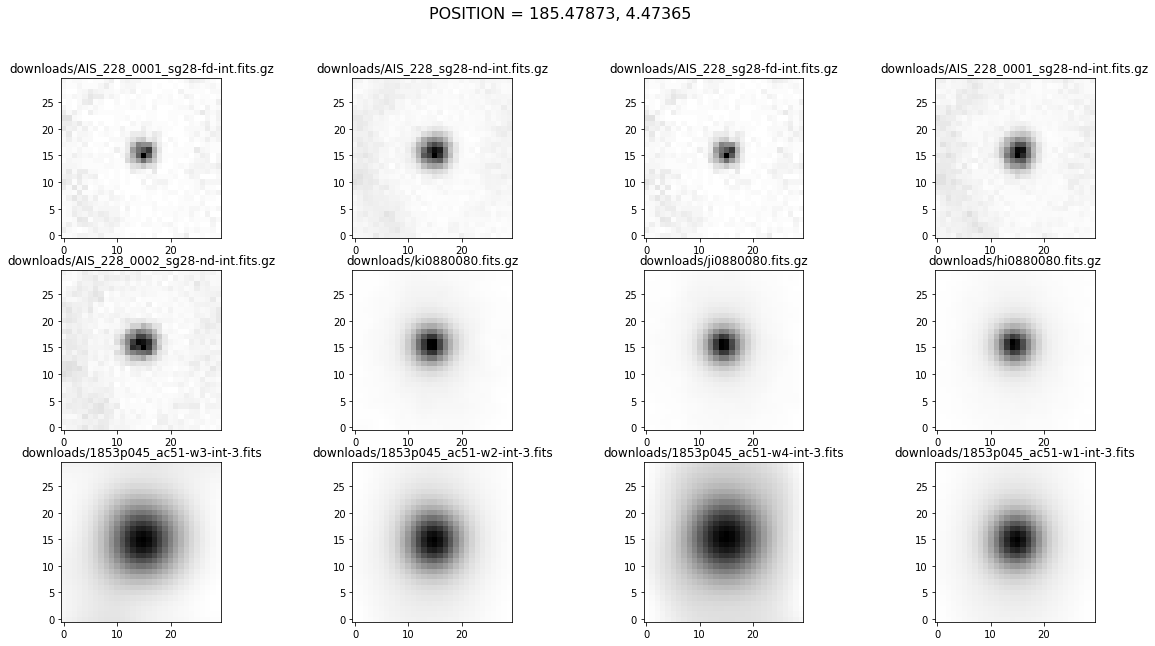

In [8]:
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import wcs
import astropy.io.fits as fits
import numpy as np
import os
from astropy.io.fits import getdata, getheader
import astropy.units as u

#Set up the figure.
fig = plt.figure(figsize=(20,10))
plt.suptitle('POSITION = ' + str(ra) + ', ' + str(dec), fontsize=16)

#For each image,
i = 0
for filename in downloaded_images['filename']:
    
    #Make the title be the filename
    filename = downloaded_images['filename'][i]
    title = filename
    
    #Read in the image, header, and WCS
    data = getdata(filename, 0)
    header = getheader(filename, 0)
    w = wcs.WCS(header)

    #Make a cutout centered on the search position, with a 30 arcsec width.
    position = SkyCoord(ra, dec, unit = 'deg')
    size = 30.0 #* u.arcsec
    cutout = Cutout2D(data, position, (size, size), wcs=w)

    #Make a subplot for this image.
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(cutout.data, cmap='gray_r', origin='lower')
    ax.set_title(title)
    
    i = i + 1
    
plt.show()

### Exercise: Sort the images by wavelength. Remove GALEX single-epoch files. Add mission labels and wavebands.

<a href = "#toc">Table of Contents</a>

<a id='simpleconesearch'></a>

## 10. Catalogs: Simple Cone Search

The Simple Cone Search (SCS) protocol is used to search a catalog for entries with positions that fall within a given search region, specified by a position and cone search radius.

More information about SCS is available here:
http://www.ivoa.net/documents/latest/ConeSearch.html

Suppose we were considering proposing for observing time with Chandra. We might first want to check whether any of our sources were already observed by Chandra, XMM or ROSAT. Below, we show the search for the table 'chanmaster', the master catalog of observed Chandra targets, with a search radius of 0.1 degrees.

In [23]:
#
# TBD alternative example for CSC
#
chandra_cone_searches = Registry.query(service_type='cone', publisher='chandra')

chandra_cone_searches.show_in_notebook()

idx,waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
0,x-ray,CSC,ivo://cxc.harvard.edu/csc,"The Chandra X-ray Observatory is the U.S. follow-on to the Einstein Observatory and one of NASA""s Great Observatories. Chandra was formerly known as AXAF, the Advanced X-ray Astrophysics Facility, but renamed by NASA in December, 1998. Originally three instruments and a high-resolution mirror carried in one spacecraft, the project was reworked in 1992 and 1993. The Chandra spacecraft carries a high resolution mirror, two imaging detectors, and two sets of transmission gratings. Important Chandra features are: an order of magnitude improvement in spatial resolution, good sensitivity from 0.1 to 10 keV, and the capability for high spectral resolution observations over most of this range. The Chandra Source Catalog (CSC) includes information about X-ray sources detected in observations obtained using the Chandra X-ray Observatory. Release 1.0 of the catalog includes about 95,000 point and compact sources with observed spatial extents less than ~30 arcsec detected in a subset of ACIS imaging observations released publicly prior to the end of 2008. Observed source positions and multi-band count rates are reported, as well as numerous derived spatial, photometric, spectral, and temporal calibrated source properties that may be compared with data obtained by other telescopes. Each record includes the best estimates of the properties of a source based on data extracted from all observations in which the source was detected. The Chandra Source Catalog is extracted from the CXC""s Chandra Data Archive (CDA). The CXC should be acknowledged as the source of Chandra data. For detailed information on the Chandra Observatory and datasets see: http://cxc.harvard.edu/ for general Chandra information; http://cxc.harvard.edu/cda/ for the Chandra Data Archive; http://cxc.harvard.edu/csc/ for Chandra Source Catalog information.",http://cda.harvard.edu/cscvo/coneSearch?,http://cxc.harvard.edu/csc/,Chandra X-ray Observatory,conesearch
1,x-ray,CDA,ivo://cxc.harvard.edu/cda,"The Chandra X-ray Observatory is the U.S. follow-on to the Einstein Observatory. Chandra was formerly known as AXAF, the Advanced X-ray Astrophysics Facility, but renamed by NASA in December, 1998. Originally three instruments and a high-resolution mirror carried in one spacecraft, the project was reworked in 1992 and 1993. The Chandra spacecraft carries a high resolution mirror, two imaging detectors, and two sets of transmission gratings. Important Chandra features are: an order of magnitude improvement in spatial resolution, good sensitivity from 0.1 to 10 keV, and the capability for high spectral resolution observations over most of this range.",http://cda.harvard.edu/cxcscs/coneSearch?,http://cxc.harvard.edu/cda/,Chandra X-ray Observatory,conesearch


### Exercise: How would you figure out the table name 'chanmaster' for yourself? Hint: combine examples 4a and 4b above.

In [32]:
search_radius = 0.1 # degrees
chandra_source_catalog = chandra_cone_searches[0]
result_list = Cone.query(skycoord_list, search_radius, chandra_source_catalog)

for i, result in enumerate(result_list):
    print(f'{len(result)} results found for {skycoord_list[i]}')

0 results found for 9.90704 8.96507
0 results found for 19.0186 46.7304
0 results found for 20.2887 40.4703
27 results found for 125.886 21.3377
0 results found for 136.002 21.9679
0 results found for 141.057 40.6372
0 results found for 146.7 22.0116
0 results found for 148.785 14.2922
0 results found for 149.751 17.8168
0 results found for 175.039 15.327
27 results found for 191.542 30.7317
0 results found for 194.913 28.8959
0 results found for 199.026 41.5011
0 results found for 206.577 43.8511
0 results found for 209.963 38.1821
0 results found for 213.556 15.6214
0 results found for 219.967 42.7421
0 results found for 226.693 12.8502
0 results found for 237.489 20.8057
0 results found for 241.519 20.8014
0 results found for 317.088 18.2002
0 results found for 329.235 6.64845
0 results found for 333.83 37.3012
0 results found for 335.756 30.9249
0 results found for 344.396 19.7827
31 results found for 348.682 4.53407
0 results found for 350.39 27.1181
0 results found for 350.438 9.

In [35]:
search_radius = 0.1 # degrees
chandra_source_catalog = chandra_cone_searches[0]
chanmaster_cone_search = {
    'access_url': 'https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl?table=chanmaster&'
}

result_list = Cone.query(skycoord_list, search_radius, service=chanmaster_cone_search)

for i, result in enumerate(result_list):
    print(f'{len(result)} results found for {skycoord_list[i]}')
    print(result)
    print('')

0 results found for 9.90704 8.96507
obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- ---- --- ----------- -------------

0 results found for 19.0186 46.7304
obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- ---- --- ----------- -------------

0 results found for 20.2887 40.4703
obsid status name  ra dec time ... exposure type  pi public_date Search_Offset
                  deg deg mjd  ...    s                  mjd                  
----- ------ ---- --- --- ---- ... -------- ---- --- ----------- -------------

1 results found for 125.886 21.3377
obsid  status      name        ra    ... type    pi    public_date Search_Offset
                              deg    ...                   mj

So we see that several galaxies in our sample have indeed already been observed, and we may wish to retrieve these images to see if they are deep enough to accomplish some of our science goals, or if we can justify additional exposures.

<a href = "#toc">Table of Contents</a>

<a id='tableaccessprotocol'></a>

## 11. Catalogs: Table Access Protocol (TAP)

We showed above how we can use NED to get the Spectral Energy Distribution of a galaxy. But if we wanted to investigate catalogs ourselves, we can use either the Simple Cone Search (SCS) Protocol above, or the Table Acess Protocol (TAP). SCS is easier to use, but limited to cone searches. TAP is more powerful, but at the cost of a bit of a learning curve. The registry examples above use TAP.

More information about TAP is available here:
http://www.ivoa.net/documents/TAP/

Let's use TAP to search the 2MASS catalog. Here we will use a synchronous query because we are doing a simple search that should return quickly. Users interested in searches that cover large areas or have complicated search criteria may wish to explore the asynchronous option.

In [2]:
#
# Exercise?
# 
irsa_tap_services = Registry.query(service_type='table', source='irsa')

irsa_tap_services.show_in_notebook()

idx,waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
0,,IRSA TAP,ivo://irsa.ipac/tap,This is IRSA's implementation of the VO Table Access Protocol (TAP). Our TAP service allows a rich variety of searches against IRSA's varied holdings.,https://irsa.ipac.caltech.edu/TAP,https://irsa.ipac.caltech.edu/docs/program_interface/TAP.html,NASA/IPAC Infrared Science Archive,tableaccess


In [4]:
#Define the search URL. Select all columns from the 2MASS Point Source Catalog (fp_psc)
#for rows that lie within 0.01 deg of the specified search position. 
tap_base_url = "https://irsa.ipac.caltech.edu/TAP"

# or
tap_service = irsa_tap_services[0]

query = """
SELECT ra,dec,j_m,h_m,k_m FROM fp_psc
where CONTAINS(POINT('J2000',ra,dec),CIRCLE('J2000',9.90704,8.96507,0.001))=1
order by ra
"""

#result_table = Tap.query(service=tap_base_url, query=query)
result_table = Tap.query(service=tap_service, query=query)

result_table.show_in_notebook()

idx,ra,dec,j_m,h_m,k_m
,deg,deg,mag,mag,mag
0,9.906258,8.965453,14.672,12.303,11.907
1,9.906989,8.965503,13.988,13.029,12.424


<a href = "#toc">Table of Contents</a>

<a id='simplespectralaccess'></a>

## Simple Spectral Access (SSA)

The Simple Spectral Access (SSA) Protocol defines a uniform interface to remotely discover and access one dimensional spectra. 

More information about SSA is avialable here:
http://www.ivoa.net/documents/SSA/

Returning to our science example, suppose that we have analyzed the available Chandra image for the matches above and discovered that one of these galaxies appears to have a potential ultraluminous X-ray source (ULX)! Now, we want to charatcterize the spectrum for this source. Therefore we will ask for a large exposure time and need to justify this by showing the spectrum of a prototypical ULX, M82 X-1.

In [2]:
#
# TBD Exercise?
# 
spectral_services = Registry.query(service_type='spectr', source='heasarc', keyword='chanmaster')

spectral_services.show_in_notebook()

idx,waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
0,x-ray,Chandra,ivo://nasa.heasarc/chanmaster,"This database table contains all of the observations made by the Chandra X-Ray Observatory (CXO, formerly known as the Advanced X-ray Astrophysics Facility or AXAF) as part of the Performance Verification and Calibration (PVC) phase and also contains all of the subsequent Cycles' Guaranteed Time Observers (GTO) and General Observer (GO) targets, and any Director's Discretionary Time (DDT) targets that have been observed. It also includes scheduled and as-yet-not-scheduled targets. The HEASARC updates this database table on a twice-weekly basis by querying the database table at the Chandra X-Ray Center (CXC) website, as discussed in the Provenance section. For observations whose status is 'archived', data products can be retrieved from the HEASARC's mirror of the CXC's Chandra Data Archive (CDA). The CXC should be acknowledged as the source of Chandra data. The PVC phase was during the first few months of the CXO mission; some of the calibration observations that are for monitoring purposes will be performed in later mission cycles. All calibration data (entries with Type = CAL in this database) are placed immediately into the CXO public data archive at the Chandra X-Ray Observatory Center (CXC); please see the Web page at &amp;lt;a href=""http://asc.harvard.edu/""&amp;gt;http://asc.harvard.edu/&amp;lt;/a&amp;gt; for more information on the CXC data archive). GTO observations during Cycle 1 or any subsequent Cycle will probably occupy 100% of months 3-4, 30% of months 5-22, and 15% of the available time for the remainder of the mission. Guaranteed Time Observers will have the same proprietary data rights as General Observers (i.e., their data will be placed in the public CXC archive 12 months after they have received the data in usable form). For detailed information on the Chandra Observatory and datasets see: &amp;lt;pre&amp;gt; &amp;lt;a href=""http://cxc.harvard.edu/""&amp;gt;http://cxc.harvard.edu/&amp;lt;/a&amp;gt; for general Chandra information &amp;lt;a href=""http://cxc.harvard.edu/cda/""&amp;gt;http://cxc.harvard.edu/cda/&amp;lt;/a&amp;gt; for the Chandra Data Archive &amp;lt;a href=""http://cxc.harvard.edu/cal/""&amp;gt;http://cxc.harvard.edu/cal/&amp;lt;/a&amp;gt; for calibration information &amp;lt;a href=""http://cxc.harvard.edu/caldb/""&amp;gt;http://cxc.harvard.edu/caldb/&amp;lt;/a&amp;gt; for the calibration database &amp;lt;a href=""http://cxc.harvard.edu/ciao/""&amp;gt;http://cxc.harvard.edu/ciao/&amp;lt;/a&amp;gt; for data analysis &amp;lt;a href=""http://cxc.harvard.edu/ciao/download/""&amp;gt;http://cxc.harvard.edu/ciao/download/&amp;lt;/a&amp;gt; for analysis software &amp;lt;a href=""http://cxc.harvard.edu/ciao/threads/""&amp;gt;http://cxc.harvard.edu/ciao/threads/&amp;lt;/a&amp;gt; for analysis threads &amp;lt;a href=""http://cda.harvard.edu/chaser/""&amp;gt;http://cda.harvard.edu/chaser/&amp;lt;/a&amp;gt; for WebChaSeR &amp;lt;/pre&amp;gt;",https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/chanmaster.html,NASA/GSFC HEASARC,simplespectralaccess
1,x-ray,Chandra,ivo://nasa.heasarc/chanmaster,"This database table contains all of the observations made by the Chandra X-Ray Observatory (CXO, formerly known as the Advanced X-ray Astrophysics Facility or AXAF) as part of the Performance Verification and Calibration (PVC) phase and also contains all of the subsequent Cycles' Guaranteed Time Observers (GTO) and General Observer (GO) targets, and any Director's Discretionary Time (DDT) targets that have been observed. It also includes scheduled and as-yet-not-scheduled targets. The HEASARC updates this database table on a twice-weekly basis by querying the database table at the Chandra X-Ray Center (CXC) website, as discussed in the Provenance section. For observations whose status is 'archived', data products can be 

In [3]:
hla_spectral_service = spectral_services[0]

m82 = SkyCoord.from_name("m82")
search_radius = 0.1 # degrees

result_list = Spectra.query(coords=m82, radius=search_radius, service=hla_spectral_service)
spec_table = result_list[0]

spec_table.show_in_notebook()

idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_ra,SSA_dec,SSA_coord_obs,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,17860,archived,M82 X-1,148.95917,69.67972,57639.7292,ACIS-S,HETG,51060,TOO,Walton,58010,57639.7292,57640.04039324745,57640.350814633915,51060.0,148.95917,69.67972,--,acisf17860N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,19791,archived,M82 X-1,148.95917,69.67972,57641.5702,ACIS-S,HETG,15310,TOO,Walton,58010,57641.5702,57641.66802275376,57641.76506558345,15310.0,148.95917,69.67972,--,acisf19791N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
2,19792,archived,M82 X-1,148.95917,69.67972,57642.353,ACIS-S,HETG,32440,TOO,Walton,58010,57642.353,57642.55836995486,57642.76294584919,32440.0,148.95917,69.67972,--,acisf19792N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


In [4]:
# The ACCESS_URL, TITLE and FORMAT columns are required to be 
# present in the results.
access_url_col = Spectra.get_column_name(spec_table, SpectraColumn.ACCESS_URL)
format_col = Spectra.get_column_name(spec_table, SpectraColumn.FORMAT)

print(f'''
access_url_col = {access_url_col}
format_col = {format_col}
''')


access_url_col = SSA_reference
format_col = SSA_format



In [7]:
## Get the first spectrum.
# The column SSA_reference is the one that contains the Access URL for the data.
# cache=True is the default, but is here to illustrate that cache can be disabled.
hdu_list=fits.open(spec_table[0][access_url_col], cache=True) 

#Print the list of spectra.
table = Table(hdu_list[1].data)
table.show_in_notebook()


idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
1,2,-2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
2,3,-1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
3,4,1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,5,2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
5,6,3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
6,7,-3,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
7,8,-2,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
8,9,-1,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005
9,10,1,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


<a href = "#toc">Table of Contents</a>